In [1]:
from unet1 import UNet
from testing_functions import *
from torchmetrics.image import StructuralSimilarityIndexMeasure
from testing_model import LightningModel
import warnings
from helper_functions import *
import matplotlib.pyplot as plt
ssim = StructuralSimilarityIndexMeasure(data_range=1.0)

In [2]:
warnings.filterwarnings('ignore')
dataset = '../Datasets/OADAT/swfd/SWFD_semicircle_RawBP-mini.h5'
input =  'sc,ss32_BP'
output = 'sc_BP'

# dataset = '../Datasets/OADAT/scd/SCD_RawBP-mini.h5'
# # input =  'vc,ss32_BP'
# # output = 'vc_BP'
# input ='ms,ss32_BP'
# output = "ms_BP"
# dataset = '../Datasets/OADAT/swfd/SWFD_multisegment_RawBP-mini.h5'
# input =  'ms,ss32_BP'
# output = 'ms_BP'
#
# dataset = '../Datasets/OADAT/msfd/MSFD_multisegment_RawBP-mini.h5'
# input =  'ms,ss32_BP_w780'
# output = 'ms_BP_w780'

In [3]:
model_pth_mouse='../final_model_weight/PAOmniNet/PA_OmniNet_Generalized.pth'

model_pth_Semi_Neuralizer= 'final_model_weight/PAOmniNet/PA_OmniNet_Generalized.pth'
model_pth_Multi_Neuralizer='final_model_weight/PAOmniNet/PA_OmniNet_Multi.pth'
model_pth_MFSD_Neuralizer=  'final_model_weight/PAOmniNet/PA_OmniNet_MSFD.pth'
model_pth_SCD_Neuralizer='final_model_weight/PAOmniNet/PA_OmniNet_SCD.pth'

model_pth_Semi_Unet= 'final_model_weight/Unet/Unet_Generalized.pth'
model_pth_Multi_Unet= 'final_model_weight/Unet/Unet_Multi.pth'
model_pth_MFSD_Unet= 'final_model_weight/Unet/Unet_MSFD.pth'
model_pth_SCD_Unet= 'final_model_weight/Unet/Unet_SCD.pth'

hparams = {
    "batch_size": 32,
    "learning_rate": 1e-4,
    "nb_levels": 4,
    "nb_inner_channels": 32,
    "nb_conv_layers_per_stage": 2,
    "data_slice_only": True,
    "max_epochs": 250,
}
Neuralizer_Semi = LightningModel(hparams)
state_dict = torch.load(model_pth_Semi_Neuralizer, map_location=torch.device('cpu'))
Neuralizer_Semi.load_state_dict(state_dict)

Neuralizer_Multi = LightningModel(hparams)
state_dict = torch.load(model_pth_Multi_Neuralizer, map_location=torch.device('cpu'))
Neuralizer_Multi.load_state_dict(state_dict)

Neuralizer_SCD = LightningModel(hparams)
state_dict = torch.load(model_pth_SCD_Neuralizer, map_location=torch.device('cpu'))
Neuralizer_SCD.load_state_dict(state_dict)

Neuralizer_MFSD = LightningModel(hparams)
state_dict = torch.load(model_pth_MFSD_Neuralizer, map_location=torch.device('cpu'))
Neuralizer_MFSD.load_state_dict(state_dict)

Unet_Semi = UNet()
Unet_Semi.load_state_dict(torch.load(model_pth_Semi_Unet, map_location=torch.device('cpu')))
Unet_Semi.eval()  

Unet_Multi = UNet()
Unet_Multi.load_state_dict(torch.load(model_pth_Multi_Unet, map_location=torch.device('cpu')))
Unet_Multi.eval()  

Unet_SCD = UNet()
Unet_SCD.load_state_dict(torch.load(model_pth_SCD_Unet, map_location=torch.device('cpu')))
Unet_SCD.eval()  

Unet_MFSD = UNet()
Unet_MFSD.load_state_dict(torch.load(model_pth_MFSD_Unet, map_location=torch.device('cpu')))
Unet_MFSD.eval()  
print('Loaded')

Loaded


In [4]:
def preprocess_Unet(image, size=(256, 256)):
    image = (image - image.min()) / (image.max() - image.min())
    image = torch.tensor(image)
    image = image.unsqueeze(0)
    return image

def preprocess_batch_Unet(images, size=(256, 256)):
    processed_images = []
    for image in images:
        processed_image = preprocess_Unet(image, size)
        processed_images.append(processed_image)
    return torch.cat(processed_images, dim=0)


In [5]:
CONTEXT_SIZE = 16

X, y = data_loader_formatter(dataset, input, output)

idx_i = 0
X, y, context_in, context_out = creating_context(X, y, idx=idx_i, context_size = 16, random=False)

X_Neuralizer = preprocess(X)
y_Neuralizer = preprocess(y)
X_Unet = preprocess_Unet(X)
y_Unet = preprocess_Unet(y)
context_in_preprocessed, context_out_preprocessed = preprocess_context(context_in, context_out)

print("Context samples:", context_in_preprocessed.shape, context_out_preprocessed.shape)
y_Neuralizer.unsqueeze(1).shape

Context samples: torch.Size([1, 16, 3, 256, 256]) torch.Size([1, 16, 3, 256, 256])


torch.Size([1, 1, 3, 256, 256])

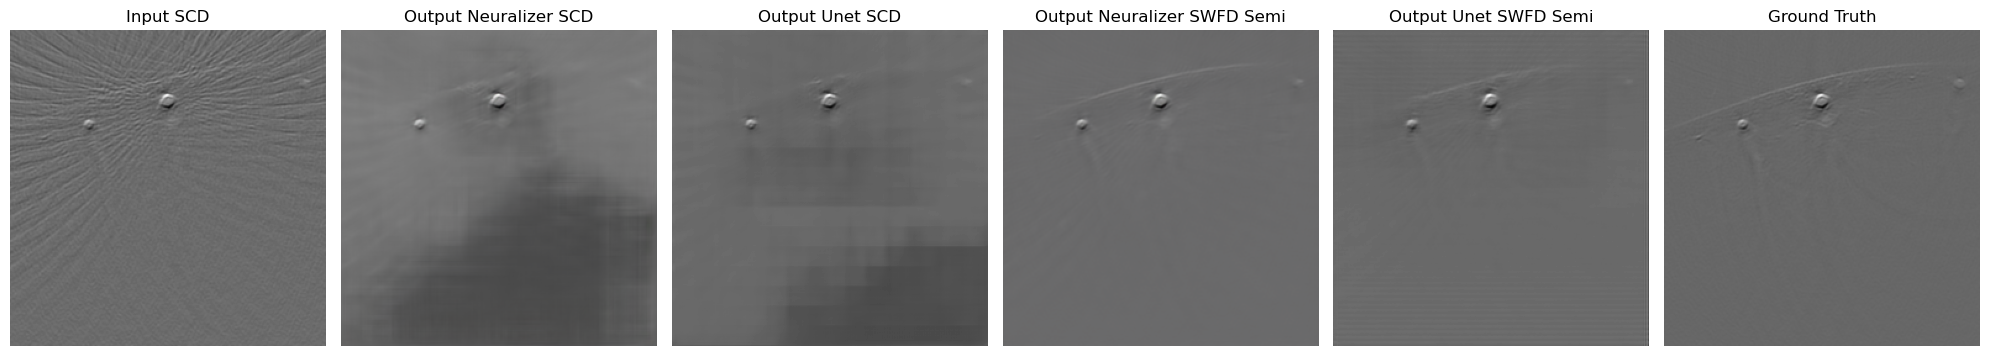

In [6]:

specific_model_unet = Unet_SCD
specific_model_neuralizer = Neuralizer_SCD
specific_name = 'SCD'

input_Unet = X_Unet
input_Unet = input_Unet.float() 
input_Unet = input_Unet.unsqueeze(0)
input_Unet = input_Unet.unsqueeze(0)
input_Neur = X_Neuralizer.unsqueeze(0)

ground_truth_Unet = y_Unet
ground_truth_Unet = ground_truth_Unet.unsqueeze(0)
ground_truth_Unet = ground_truth_Unet.unsqueeze(0)
ground_truth_Neur = y_Neuralizer.unsqueeze(0)

output_Neur = Neuralizer_Semi.forward(input_Neur, context_in_preprocessed, context_out_preprocessed)
output_Neur_specific = specific_model_neuralizer.forward(input_Neur, context_in_preprocessed, context_out_preprocessed)
output_Unet_Semi = Unet_Semi(input_Unet.squeeze(0))
output_Unet_Specific = specific_model_unet(input_Unet.squeeze(0))

normalized_output_Neur = (output_Neur - output_Neur.min()) / (output_Neur.max() - output_Neur.min())
normalized_output_Semi = (output_Unet_Semi - output_Unet_Semi.min()) / (output_Unet_Semi.max() - output_Unet_Semi.min())
normalized_output_Neur_specific = (output_Neur_specific - output_Neur_specific.min()) / (output_Neur_specific.max() - output_Neur_specific.min())
normalized_output_Specific = (output_Unet_Specific - output_Unet_Specific.min()) / (output_Unet_Specific.max() - output_Unet_Specific.min())

# rmse_val_base = compute_rmse(ground_truth_Neur, input_Neur)
# psnr_val_base = compute_psnr(ground_truth_Neur, input_Neur)
# ssim_val_base = ssim(ground_truth_Neur, input_Neur).item()

# rmse_val_neur = compute_rmse(ground_truth_Neur.squeeze(0), normalized_output_Neur.squeeze(0))
# psnr_val_neur = compute_psnr(ground_truth_Neur.squeeze(0), normalized_output_Neur.squeeze(0))
# ssim_val_neur = ssim(ground_truth_Neur, normalized_output_Neur.unsqueeze(dim=1)).item()

# rmse_val_neur_specific = compute_rmse(ground_truth_Neur, normalized_output_Neur_specific.squeeze(0))
# psnr_val_neur_specific = compute_psnr(ground_truth_Neur, normalized_output_Neur_specific.squeeze(0))
# ssim_val_neur_specific = ssim(ground_truth_Neur.unsqueeze(0), normalized_output_Neur_specific).item()

# rmse_semi = compute_rmse(ground_truth_Unet, normalized_output_Semi)
# psnr_semi = compute_psnr(ground_truth_Unet, normalized_output_Semi)
# ssim_semi = ssim(ground_truth_Unet, normalized_output_Semi).item()

# rmse_specific = compute_rmse(ground_truth_Unet, normalized_output_Specific)
# psnr_specific = compute_psnr(ground_truth_Unet, normalized_output_Specific)
# ssim_specific = ssim(ground_truth_Unet, normalized_output_Specific).item()

normalized_output_Neur_img = normalized_output_Neur.squeeze().permute(1,2,0).cpu().detach().numpy()
normalized_output_Neur_img_specific = normalized_output_Neur_specific.squeeze().permute(1,2,0).cpu().detach().numpy()
normalized_output_Semi_img = normalized_output_Semi.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
normalized_output_Specific_img = normalized_output_Specific.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
ground_truth_img = ground_truth_Unet.squeeze().cpu().numpy()

titles = [
    f'Input {specific_name}',
    f'Output Neuralizer {specific_name}', f'Output Unet {specific_name}',
    'Output Neuralizer SWFD Semi', 'Output Unet SWFD Semi', 'Ground Truth']
images = [X, 
          normalized_output_Neur_img_specific, normalized_output_Specific_img,
          normalized_output_Neur_img, normalized_output_Semi_img, y]

plt.figure(figsize=(20, 5))
for idx, (title, img) in enumerate(zip(titles, images)):
    plt.subplot(1, 6, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()
# 
# print(f'Base: SSIM {ssim_val_base}, RMSE: {rmse_val_base}, PSNR: {psnr_val_base}')
# print(f'Neuralizer Specific: SSIM {ssim_val_neur_specific}, RMSE: {rmse_val_neur_specific}, PSNR: {psnr_val_neur_specific}')
# print(f'Neuralizer: SSIM {ssim_val_neur}, RMSE: {rmse_val_neur}, PSNR: {psnr_val_neur}')
# print(f'Unet Semi: SSIM {ssim_semi}, RMSE: {rmse_semi}, PSNR: {psnr_semi}')
# print(f'Unet Specific: SSIM {ssim_specific}, RMSE: {rmse_specific}, PSNR: {psnr_specific}')
